In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.nonparametric.smoothers_lowess import lowess
sns.set()

# yvr, yvrCases
# %store -r

In [2]:
yvr = pd.read_csv('yvr4analyze_both.csv')
yvrCases = pd.read_csv('Covid-Data/yvr-modified.csv')

# For some reason, the "Date" column wasn't being interpeted by the parsing arguments through input
# Or in pd.to_csv(). So we need to reformat it into datetime type when we reimport it
# It wasn't an issue when it was indirectly referenced via %store so maybe converting it csv 
# wiped out something? <-- bc of changing col numbers in csv files bc of how index col is sometimes read properly, sometimes not

yvr["Date"] = pd.to_datetime(yvr["Date"])
yvrCases["Date"] = pd.to_datetime(yvrCases["Date"])

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


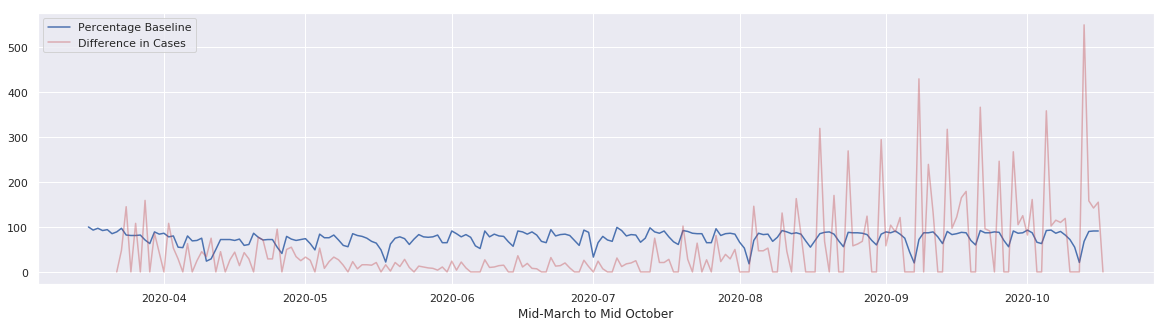

In [3]:
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yvrCases["Date"], yvrCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

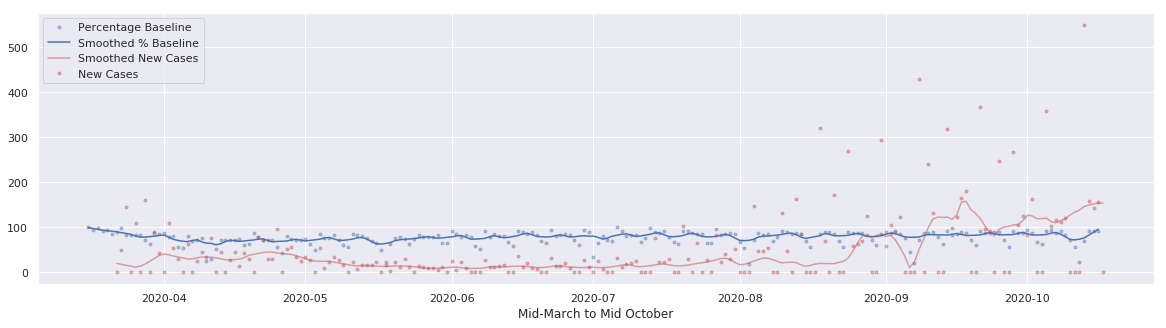

In [55]:
# We see that new cases per day is 0 sometimes, which isn't actually true, just that maybe
# the cases found for a couple of days aren't logged that day, but instead logged on another day, so we should
# smooth the new cases over a couple of days
# We also want to smooth out the weekly cycles in the data to see the long-run correlations
from statsmodels.nonparametric.smoothers_lowess import lowess
new_cases_smooth = lowess(yvrCases['Difference'], yvrCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yvr['PercentOfBaseline'], yvr["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yvrCases['Diff_smooth'] = new_cases_smooth[:,1]
yvr['Baseline_smooth'] = baseline_smooth[:,1]

#print(joined.count())
#can use X,y or original, doesn't really matter
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yvr["Date"], yvr['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yvrCases["Date"], yvrCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()
# This is to make sure both yvr and yvrCases start and end on the same dates
if (yvr.count().loc['Date'] != yvrCases.count().loc['Date']):
    joined = yvrCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yvr[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yvrCases["Diff_smooth"]
    y = yvr["Baseline_smooth"]

0.3320289080751595


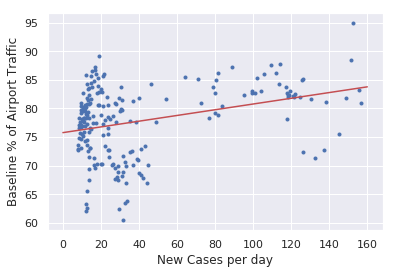

In [5]:
# Is there statistical correlation between the two values- Baseline, and New Cases?
# We use smoothed versions of data because don't want to analyze the weekly noise (tho holidays still exist)
# y = Diff
from scipy import stats
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)
print(regression.rvalue)
linearX = np.linspace(0,160)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')
#Data, especially X is unbalanced really. The r-value is too low to indicate some sort of relation between
# the two pieces of data

rval of linear regression 0.4826338984856044


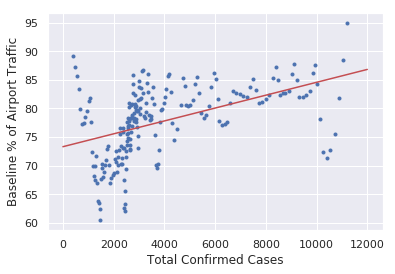

In [6]:
# What about confirmed?
#smooth it, and then plot it
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')
reg = stats.linregress(confirmX, y)
print("rval of linear regression",reg.rvalue)
linearX = np.linspace(0,12000)
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')
# slightly better but not close enough. Interesting to see that consistent dip in airport traffic when the 
# total was around 2000 this was probably due to the inital shock in the early parts of the pandemic


0.6275585034910569
0.5073977846395337


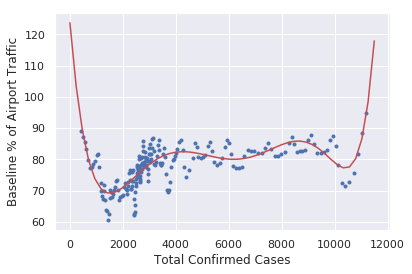

In [52]:
# It doesn't seem like linear regression is what we want, let's try a polynomial
# The data shows 2 dips --> matches with knowledge of the two waves
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X = np.stack([confirmX], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,y)
poly_regress = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=8, include_bias = True),
    LinearRegression(fit_intercept = False))
poly_regress.fit(X_train, y_train)
linearX = np.stack([np.linspace(0,11500)],axis=1)
plt.plot(linearX, poly_regress.predict(linearX), 'r-')
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))
# Oh hey we get something pretty good, but with poly regression, we can't exactly 
# predict into the future

-0.4693023697196383
-0.9176082647508533


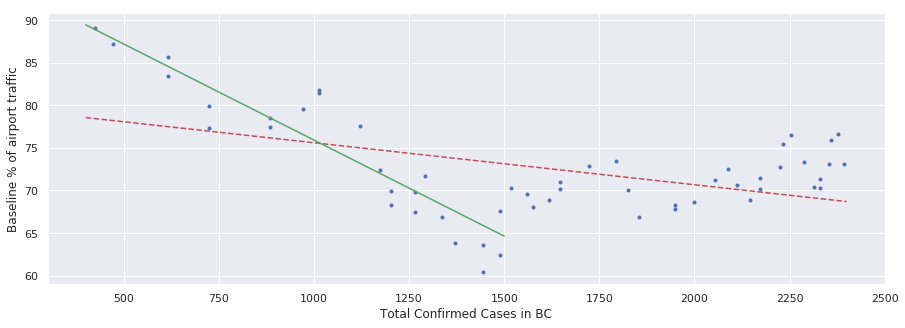

In [89]:
# Analyzing statistical correlation in --> full first wave
first_wave = joined[joined['Date']<'2020-05-15']
plt.figure(figsize = (15,5))
"""plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: First Wave")
plt.legend()
plt.show() #two things over time"""
plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.')
plt.xlabel("Total Confirmed Cases in BC")
plt.ylabel("Baseline % of airport traffic")
regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)
linearX = np.linspace(400,2400)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--')

# We can clearly see that while there was a huge decrease in airport traffic in the 
# beginning, but it recovered over time back to the new normal
# how about when we try to only look at the first 25 days? 
reg2 = stats.linregress(first_wave["Confirmed"].head(25), first_wave["Baseline_smooth"].head(25))
print(reg2.rvalue)
lin2 = np.linspace(400,1500)
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--')
# get rvalue showing there is indeed a close linear correlation in the first 'shock'
# but later on, no longer the same correlation

In [87]:
# Build total + new global cases, NA cases
first_wave

,Date,Difference,Confirmed,Diff_smooth,PercentOfBaseline,Baseline_smooth
0,2020-03-22,0.0,424,19.188331,89.0,89.101704
1,2020-03-23,48.0,472,16.756408,97.0,87.151708
2,2020-03-24,145.0,617,14.642134,82.0,85.616484
3,2020-03-25,0.0,617,12.936730,81.0,83.408398
4,2020-03-26,108.0,725,10.806539,81.0,79.897849
5,2020-03-27,0.0,725,12.727754,82.0,77.326508
6,2020-03-28,159.0,884,17.498581,71.0,77.484605
7,2020-03-29,0.0,884,23.514868,63.0,78.475088
8,2020-03-30,86.0,970,29.993234,89.0,79.534617
9,2020-03-31,43.0,1013,36.928460,84.0,81.368314


In [ ]:
# ML with new cases, total cases, global cases: total + new, vs y= Baseline

# YEG

In [ ]:
yeg = pd.read_csv('yeg4analyze_both.csv',index_col =0, parse_dates = [1])
yegCases = pd.read_csv('Covid-Data/yeg-modified.csv', index_col =0, parse_dates = [5])

yeg["Date"] = pd.to_datetime(yeg["Date"])
yegCases["Date"] = pd.to_datetime(yegCases["Date"])

yegCases.loc[0, "Difference"] = 0

In [ ]:
yegCases

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yegCases["Date"], yegCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yegCases["Date"], yegCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

In [ ]:
# Small curve in initial phase (Mid-Apr), flattened down shortly after 
# Steep increases after the Summer - look for causes 
# Called in military to assist with rising cases; lockdown
# % Baseline didn't change dramatically (decrease in business trips and international travel)
# Small dips

new_cases_smooth = lowess(yegCases['Difference'], yegCases["timestamp"], frac =0.05)
#to reduce weekly cycle effect 7/214 = 0.327
baseline_smooth = lowess(yeg['PercentOfBaseline'], yeg["Date"], frac =0.04) 
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yeg['Baseline_smooth'] = baseline_smooth[:,1]

# Ensure both yeg and yegCases start and end on the same dates
if (yeg.count().loc['Date'] != yegCases.count().loc['Date']):
    joined = yegCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yeg[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yegCases["Diff_smooth"]
    y = yeg["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yeg["Date"], yeg['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yegCases["Date"], yegCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yegCases["Date"], yegCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

In [ ]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

# 311 = max(X)
linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')

# r-value: Slight but negligible correlation 
# imbalanced data??

In [ ]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')

# r-value: slight positive correlation 

In [ ]:
temp = yeg.shift(-1)

X = np.array(yeg['PercentOfBaseline'].head(100)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(100)).astype(int).reshape(-1, 1)

In [ ]:
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
linearX = np.linspace(0,100).reshape(-1, 1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

# ???

# YUL

In [ ]:
yul = pd.read_csv('yul4analyze_both.csv',index_col =0, parse_dates = [1])
yulCases = pd.read_csv('Covid-Data/yul-modified.csv', index_col =0, parse_dates = [5])

yul["Date"] = pd.to_datetime(yul["Date"])
yulCases["Date"] = pd.to_datetime(yulCases["Date"])

yulCases.loc[0, "Difference"] = 0

In [ ]:
# Well thats a funky looking plot.

plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yulCases["Date"], yulCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yulCases["Date"], yulCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

In [ ]:
# baseline seems constant; except for the small dip in March
# Find factors to attribute to the two curves - small bump in the summer?
# The second one might be an instance to not increase flights to YUL

new_cases_smooth = lowess(yulCases['Difference'], yulCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yul['PercentOfBaseline'], yul["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yulCases['Diff_smooth'] = new_cases_smooth[:,1]
yul['Baseline_smooth'] = baseline_smooth[:,1]
# Ensure both yul and yulCases start and end on the same dates
if (yul.count().loc['Date'] != yulCases.count().loc['Date']):
    joined = yulCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yul[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yulCases["Diff_smooth"]
    y = yul["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yul["Date"], yul['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yulCases["Date"], yulCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yulCases["Date"], yulCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

In [ ]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above

plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')

# neglible correlation. so assume none at all - look into possible factors
# are people still travelling, or not travelling?

In [ ]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')

# this is pretty interesting - strong indication of positive correlation

In [ ]:
temp = yul.shift(-1)

X = np.array(yul['PercentOfBaseline'].head(100)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(100)).astype(int).reshape(-1, 1)

In [ ]:
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
linearX = np.linspace(0,100).reshape(-1, 1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()